In [1]:
import argparse
import os
from copy import deepcopy
from typing import Optional, Tuple

import gymnasium as gym
import numpy as np
import torch
from pettingzoo.classic import hanabi_v4
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, PrioritizedVectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import (
    BasePolicy,
    RainbowPolicy,
    MultiAgentPolicyManager,
    RandomPolicy,
    DQNPolicy
)
from tianshou.utils.net.discrete import NoisyLinear
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pettingzoo.classic.hanabi.hanabi import raw_env
from pettingzoo.classic.hanabi.hanabi import raw_env
from typing import Dict, List, Optional, Union

import gymnasium
import numpy as np
from gymnasium import spaces
from gymnasium.utils import EzPickle

from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
from hanabi_learning_environment.rl_env import HanabiEnv

In [2]:
# copy of rainbow used in deepmind paper
p = {
    'hidden_layers': [128,128],
    'gamma': 0.99,
    'lr': 1e-5,
    'target_update_freq': 500,
    'estimation_steps': 1,
    'num_train':50,
    'num_test':50,
    'buffer_size':50000,
    'vmax':25,
    'vmin':-25,
    'noisy_std':0.1,
    'atom_size':51,
    'minimum_replay_history':50000,
    'batch_size':32,
    'steps_per_collect': 10000,
    'updates_per_train': 1500,
    'test_steps': 10000,
    'epochs':5000,
    'eps_decay_period': 200,
    'test_frequency': 3,
    'test_eps': 0,
    'save_frequency': 25,
    'eps_final':0.01,
    'adam_eps': 3.125e-5,
    'path': 'results_dqn_infinite/',
    'lr_scheduler_factor': 0.1,
    'lr_scheduler_patience': 20
}


In [3]:
class raw_env_overwrite(raw_env):
    def __init__(
        self,
        colors: int = 5,
        ranks: int = 5,
        players: int = 2,
        hand_size: int = 5,
        max_information_tokens: int = 8,
        max_life_tokens: int = 3,
        observation_type: int = 1,
        random_start_player: bool = False,
        render_mode: Optional[str] = None,
    ):
        EzPickle.__init__(
            self,
            colors,
            ranks,
            players,
            hand_size,
            max_information_tokens,
            max_life_tokens,
            observation_type,
            random_start_player,
            render_mode,
        )

        # Check if all possible dictionary values are within a certain ranges.

        self._config = {
            "colors": colors,
            "ranks": ranks,
            "players": players,
            "hand_size": hand_size,
            "max_information_tokens": max_information_tokens,
            "max_life_tokens": max_life_tokens,
            "observation_type": observation_type,
            "random_start_player": random_start_player,
        }
        self.hanabi_env: HanabiEnv = HanabiEnv(config=self._config)

        # List of agent names
        self.agents = [f"player_{i}" for i in range(self.hanabi_env.players)]
        self.possible_agents = self.agents[:]

        self.agent_selection: str

        # Sets hanabi game to clean state and updates all internal dictionaries
        self.reset()

        # Set action_spaces and observation_spaces based on params in hanabi_env
        self.action_spaces = {
            name: spaces.Discrete(self.hanabi_env.num_moves()) for name in self.agents
        }
        self.observation_spaces = {
            player_name: spaces.Dict(
                {
                    "observation": spaces.Box(
                        low=0,
                        high=1,
                        shape=(self.hanabi_env.vectorized_observation_shape()[0],),
                        dtype=np.float32,
                    ),
                    "action_mask": spaces.Box(
                        low=0,
                        high=1,
                        shape=(self.hanabi_env.num_moves(),),
                        dtype=np.int8,
                    ),
                }
            )
            for player_name in self.agents
        }

        self.render_mode = render_mode
        
class HanabiScorePenalty:
    def __init__(self, env):
        self.env = env

    def __float__(self):
        return -float(self.env.hanabi_env.state.score())

def env(**kwargs):
    render_mode = kwargs.get("render_mode")
    if render_mode == "ansi":
        kwargs["render_mode"] = "human"
        env = raw_env_overwrite(**kwargs)
        env = wrappers.CaptureStdoutWrapper(env)
    else:
        env = raw_env_overwrite(**kwargs)

    env = wrappers.TerminateIllegalWrapper(env, illegal_reward=HanabiScorePenalty(env))
    env = wrappers.AssertOutOfBoundsWrapper(env)
    env = wrappers.OrderEnforcingWrapper(env)
    return env

In [4]:
def get_env(render_mode=None):
    return PettingZooEnv(env(colors=1, ranks=5, players=2, hand_size=2, max_information_tokens=10,
max_life_tokens=1, observation_type=1))

In [5]:
def get_agents(p):
    
    # Return Policy, Agents, Envs
    env = get_env()
    observation_space = env.observation_space['observation'] if isinstance(
    env.observation_space, gym.spaces.Dict
    ) else env.observation_space

    state_shape = observation_space.shape or observation_space.n
    action_shape = env.action_space.shape or env.action_space.n
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = Net(
            state_shape,
            action_shape,
            hidden_sizes=p['hidden_layers'],
            device = device,
    )

    optim = torch.optim.Adam(net.parameters(), lr= p['lr'], eps=p['adam_eps'])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode = 'max', factor = p['lr_scheduler_factor'],
                                                              patience = p['lr_scheduler_patience'])

    agent = agent = DQNPolicy(
            net,
            optim,
            p['gamma'],
            p['estimation_steps'],
            target_update_freq=p['target_update_freq']
        ).to(device)

    agents = [agent, agent]
    policy = MultiAgentPolicyManager(agents, env)
    agents = env.agents

    train_envs = DummyVectorEnv([get_env for _ in range(p['num_train'])])
    test_envs = DummyVectorEnv([get_env for _ in range(p['num_test'])])
    
    return policy, agents, train_envs, test_envs, lr_scheduler

In [6]:
def get_collectors(
    policy,
    train_envs,
    test_envs,
    p
):
    
    # Get collectors
    train_collector = Collector(
    policy,
    train_envs,
    PrioritizedVectorReplayBuffer(p['buffer_size'], len(train_envs), alpha = 0.6, beta = 0.4, weight_norm=True),
    exploration_noise=True)
    
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    
    return train_collector, test_collector

In [7]:
def initialize_buffer(
    train_collector,
    agents,
    policy,
    p
):
    for a in agents:
        policy.policies[a].set_eps(1)
    train_collector.collect(n_step = p['minimum_replay_history'])

In [8]:
def save_policy(policy, agents, p):
    for a in agents:
        torch.save(policy.policies[a].state_dict(), f'{p["path"]}{a}_params.pth')

def save_history(history, p):
    np.save(f'{p["path"]}training_rewards.npy', np.array(history))
    
def change_lr(optimizer, new_lr):
    # Run this to change the learning rate to 1e-5:
    for g in optimizer.param_groups:
        g['lr'] = new_lr

In [9]:
def get_eps(iteration, p):
    if iteration > p['eps_decay_period']:
        return p['eps_final']
    else:
        gradient = (1 - p['eps_final'])/p['eps_decay_period']
        return 1 - gradient*iteration
        
def set_eps(policy, agents, new_eps):
    for a in agents:
        policy.policies[a].set_eps(new_eps)
        
def train(
    policy,
    train_collector,
    test_collector,
    agents,
    p,
    lr_scheduler,
    training_history = []
):

    for i in tqdm(range(p['epochs'])):
        
        eps = get_eps(i, p)
        set_eps(policy, agents, eps)
        
        # Collection step
        try:
            result = train_collector.collect(n_step = p['steps_per_collect'])
        except:
            train_collector.reset()
            train_collector.reset_env()
            print('Failed')
            result = train_collector.collect(n_step = 2*p['minimum_replay_history'])
            
        # Test Step
        if i%p['test_frequency'] == 0:
            set_eps(policy, agents, p['test_eps'])
            try:
                result = test_collector.collect(n_step = p['test_steps'])
                mean_reward = result['rews'].mean()
                tqdm.write(str(mean_reward))
                training_history.append(mean_reward)
                set_eps(policy, agents, eps)
                lr_scheduler.step(mean_reward)
            except:
                test_collector.reset()
                test_collector.reset_env()
                print('failed')
                result = test_collector.collect(n_step = p['test_steps'])
                
    
        if i%p['save_frequency'] == 0:
            save_policy(policy, agents,p)
            save_history(training_history,p)
            plot_and_save(training_history, p['test_frequency'],p, show = False)
    
        # Update step (one epoch)
        for _ in range(p['updates_per_train']): 
            losses = policy.update(p['batch_size'], train_collector.buffer)
    
    plot_and_save(training_history, test_frequency)
        

In [10]:
def plot_and_save(training_history, test_frequency, p, save = True, show = True):
    x = np.arange(len(training_history))
    x *= test_frequency
    plt.plot(x, training_history)
    plt.title('Average Score (Cheating DQN, 1 Color game)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Score (max 5)')
    if save: plt.savefig(f'{p["path"]}training_curve.png')
    if show:
        plt.show()
    else:
        plt.close()
        
def load(policy, agents, p):
    for a in agents:
        policy.policies[a].load_state_dict(torch.load(f'{p["path"]}{a}_params.pth'))
    his = list(np.load(f'{p["path"]}training_rewards.npy'))
    return his

In [11]:
policy, agents, train_envs, test_envs, lr_scheduler = get_agents(p)
train_collector, test_collector = get_collectors(policy, train_envs, test_envs, p)
initialize_buffer(train_collector, agents, policy, p)

/home/cfs/mh2004/anaconda3/lib/python3.9/site-packages/tianshou/data/batch.py:546: UserWarning: You are using tensors with different shape, fallback to dtype=object by default.
  warnings.warn(
/home/cfs/mh2004/anaconda3/lib/python3.9/site-packages/tianshou/data/batch.py:546: UserWarning: You are using tensors with different shape, fallback to dtype=object by default.
  warnings.warn(


In [12]:
training_history = load(policy, agents,p)
#training_history = []

In [13]:
train(policy, train_collector, test_collector, agents, p, lr_scheduler, training_history = training_history)

  0%|          | 0/5000 [00:00<?, ?it/s]

4.836092715231788


/home/cfs/mh2004/anaconda3/lib/python3.9/site-packages/tianshou/data/batch.py:546: UserWarning: You are using tensors with different shape, fallback to dtype=object by default.
  warnings.warn(


3.1806451612903226
3.5913757700205338
3.898989898989899
4.132
4.348514851485149
4.460500963391137
4.521235521235521
4.59392789373814
4.578544061302682
4.514177693761814
4.333969465648855
4.512195121951219
4.409005628517824
4.569316081330869
4.678966789667896
4.669104204753199
4.61524500907441
4.670349907918968
4.7202166064981945
4.55822550831793
4.612844036697248
4.620938628158845
4.648648648648648
4.716049382716049
4.686594202898551
4.680926916221034
4.648214285714285
4.678383128295255
4.750439367311072
4.770434782608696
4.659090909090909
4.75
4.726027397260274
4.777777777777778
4.812816188870152
4.767169179229481
4.788429752066116
4.780730897009967
4.761750405186386
4.810897435897436
4.797101449275362
4.827361563517916
4.825320512820513
4.775080906148867
4.779742765273312
4.776886035313002
4.831478537360891
4.815705128205129
4.836477987421383
4.81658692185008
4.84433962264151
4.8246445497630335
4.8289676425269645
4.832049306625578
4.814241486068111
4.856923076923077
Failed
4.82848392

KeyboardInterrupt: 

In [11]:
policy, agents, train_envs, test_envs, lr_scheduler = get_agents(p)
train_collector, test_collector = get_collectors(policy, train_envs, test_envs, p)

In [12]:
_ = load(policy, agents, p)

In [13]:
set_eps(policy, agents, 0)
result = test_collector.collect(n_step = 150000)

/home/cfs/mh2004/anaconda3/lib/python3.9/site-packages/tianshou/data/batch.py:546: UserWarning: You are using tensors with different shape, fallback to dtype=object by default.
  warnings.warn(


In [14]:
rewards = result['rews'][:,1]
average_score = round(np.mean(rewards),2)
print(f'Total games = {len(rewards)}')
print(f'Average score = {average_score}')

Total games = 9796
Average score = 4.83


In [15]:
games_played = len(rewards)
heights = np.zeros(6)
x = [str(i) for i in range(6)]
for i in range(6):
    heights[i] = np.sum(rewards==i)
percentages = heights*100/games_played
print(sum(percentages))

100.0


In [16]:
cheating_percentages = [0, 0.58, 2.87, 6.08, 15.87, 75.61]

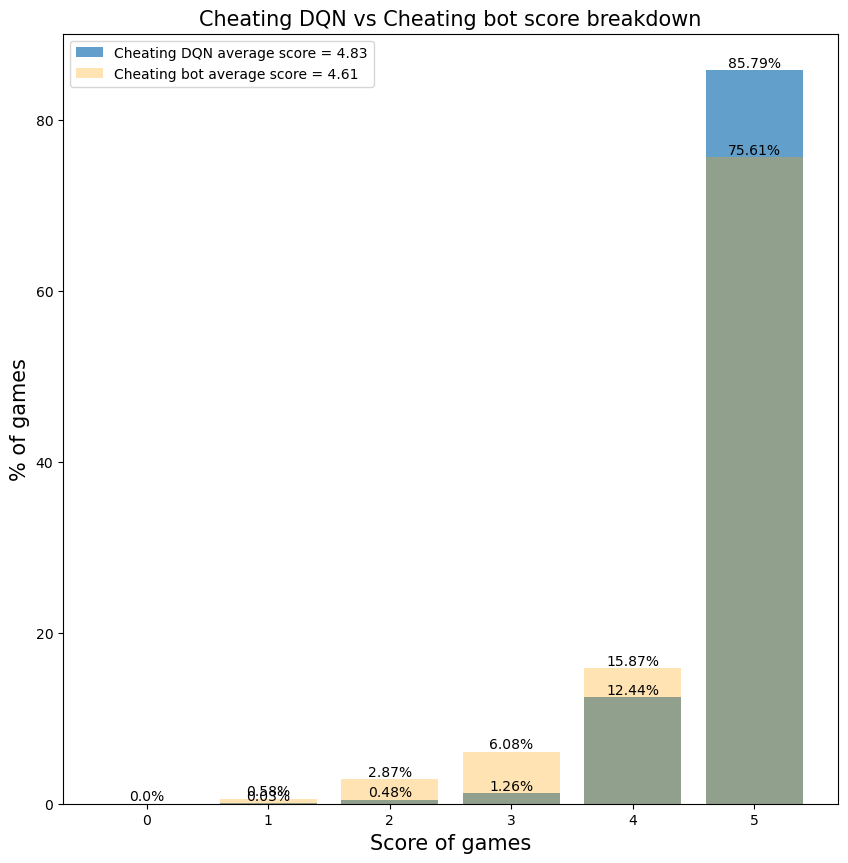

In [18]:
fig = plt.figure(figsize=(10,10))
plt.bar(x, percentages, label = f'Cheating DQN average score = {average_score}', alpha = 0.7)
plt.bar(x, cheating_percentages, label = f'Cheating bot average score = {4.61}', alpha = 0.3, color = 'orange')
for r,f in zip(x, percentages):
    plt.annotate(f'{round(f,2)}%', (r,f), ha='center', va='bottom')
for r,f in zip(x[1:], cheating_percentages[1:]):
    plt.annotate(f'{round(f,2)}%', (r,f), ha='center', va='bottom')
plt.ylabel('% of games', fontsize = 15)
plt.xlabel('Score of games', fontsize = 15)
plt.title('Cheating DQN vs Cheating bot score breakdown', fontsize = 15)
plt.legend()
plt.savefig(f'{p["path"]}/cheating_dqn_vsmall_breakdown.png')
plt.show()